# Pre-processing the NICT JLE dataset

## TODO: explanation : regular expressions - used pattern for tags

In [6]:
import re
from os import listdir

# This function allows you to retrieve all the lines that are between the "B" tag and remove the new line
def generateCleanFile(filename):
    input = open("NICT_JLE_4.1/LearnerOriginal/" + filename, "r", encoding="latin1") 
    output = open("preProcessedData/" + filename, "w", encoding="latin1")
    lines = input.readlines()
    for line in lines:
        if '<B>' in line :
            output.write(line[3:len(line)-5])
            #output.write(line[3:len(line)-5])
    input.close()
    output.close() 

# This function allows each line of each file to delete all tags and their data
def generateCleanline(filename):
    input = open("preProcessedData/" + filename, "r", encoding="latin1")
    output = open("preProcessedDataLine/" + filename, "w", encoding="latin1")
    lines = input.readlines()
    for line in lines:
            content = removeAllInternalTags(line)
            output.write(content.lower())
    input.close()
    output.close() 


def removeAllInternalTags(line):
    pile = list()
    pile = [(m.start(0), m.end(0)) for m in re.finditer(r'<(.*?)>', line)]

    buffer = []
    counter = 0
    while len(pile) != 0:
        if line[pile[counter][0]+1] == '/':
            line = line[0:buffer[-1][0]] + line[pile[counter][1]:]
            pile = [(m.start(0), m.end(0)) for m in re.finditer(r'<(.*?)>', line)]
            counter = 0
            buffer.pop()
        else :
            buffer.append(pile[counter])
            counter+=1
    return line

# Keep only signaficant tags that will help with the prediction of the SST level of each participant 
# tags is the list of tags that the user wants to remove from the transcript 
def removeInternalTags(line, tags=[]):
    for tag in tags:
        doubleTagPattern = "<",tag,">(.+?)</",tag,">"
        singleTagPattern = "</?",tag,"*?>"
        line = re.sub(doubleTagPattern, "", line)
        line = re.sub(singleTagPattern, "", line)
    return re.sub(r"\s+", " ", line)


files = [f for f in listdir("NICT_JLE_4.1/LearnerOriginal")]

for f in files:
    generateCleanFile(f)
    
for f in files:
    generateCleanline(f)


# Processing the dataset: Bag of Words

explanation : BoW algo - stopwords


A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

    A vocabulary of known words.
    A measure of the presence of known words.

It is called a bag-of-words , because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document. The complexity comes both in deciding how to design the vocabulary of known words (or tokens) and how to score the presence of known words.

#### Associate text file and score

In [2]:
from os import listdir

def extractScore(filename):
    score = {}
    input = open("NICT_JLE_4.1/LearnerOriginal/" + filename, "r", encoding="latin1") 
    lines = input.readlines()
    for line in lines:
        if '<SST_level>' in line :
            score = line[11]
            break
    input.close()
    return score

files = [f for f in listdir("NICT_JLE_4.1/LearnerOriginal")]

textScoreList = dict()

for f in files:
    textScoreList[f] = extractScore(f)

#### Create vocabulary 

As a first step, we create the function for generating the vocabulary 

In [3]:
from nltk.corpus import stopwords
from os import listdir
import numpy
import re
from sklearn.feature_extraction.text import CountVectorizer

def createVectorizer(text):
    vectorizer = CountVectorizer()
    vectorizer.fit(text)
    return vectorizer

def word_extraction(sentence):    
    ignore = set(stopwords.words('english')) 
    words = sentence.split()
    cleaned_text = [w.lower() for w in words if w not in ignore] 
    return ' '.join(cleaned_text)
    
# def tokenize(sentences):    
#     words = []    
#     for sentence in sentences:        
#         w = word_extraction(sentence)        
#         words.extend(w)            
#         words = sorted(list(set(words)))  
#     return words

#### Dividing database to training and testing sets randomly 

In [4]:
from random import shuffle
from math import floor
import os

allFiles = os.listdir("preProcessedDataLine/")

# Randomize training data
shuffle(allFiles)

split = 0.6

split_index = floor(len(allFiles) * split)
trainingFiles = allFiles[:split_index]
testingFiles = allFiles[split_index:]


#### Creating vocab from training dataset

In [5]:
trainingText = list()
testingText = list()

for trainingFile in trainingFiles:
    trainingFileText = open("preProcessedDataLine/" + trainingFile, "r", encoding="latin1")
    l = trainingFileText.readline()
    trainingText.append(word_extraction(l))
    trainingFileText.close()

for testingFile in testingFiles:
    testingFileText = open("preProcessedDataLine/" + testingFile, "r", encoding="latin1")
    l = testingFileText.readline()
    testingText.append(word_extraction(l))
    testingFileText.close()

vectorizer = createVectorizer(trainingText)

trainingVector = vectorizer.transform(trainingText) 
testingVector = vectorizer.transform(testingText) 

trainingData = trainingVector.toarray() 
testingData = testingVector.toarray()


#### Generate BoW vectors for training data 

In [52]:
import pandas as pd


# dataframe for training data : inputs
x_train = pd.DataFrame(trainingData, columns = sorted(vectorizer.vocabulary_))
x_train.index = trainingFiles

# dataframe for training data : scores
y_train = pd.DataFrame([textScoreList[trainingFile] for trainingFile in trainingFiles], columns = ["score"])
y_train.index = trainingFiles


# dataframe for testing data : inputs
x_test = pd.DataFrame(testingData, columns = sorted(vectorizer.vocabulary_))
x_test.index = testingFiles

# dataframe for testing data : scores
y_test = pd.DataFrame([textScoreList[testingFile] for testingFile in testingFiles], columns = ["score"])
y_test.index = testingFiles

# remove columns that have more that 70% of values equal to zero
#x_train = x_train.loc[:, (x_train==0).mean() < .7]
#x_test = x_test[x_train.columns]

# Training the classifier to Predict SST

Explain the "process" of choosing a classifier 

In [53]:
print(len(sorted(vectorizer.vocabulary_)))
print(x_train.shape)
print(x_test.shape)

9746
(768, 9746)
(513, 9746)


In [55]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
#Initializing and fitting models on Training Data
#Naive Bayes Model

nb = MultiOutputClassifier(MultinomialNB()).fit(x_train, y_train)
y_pred = nb.predict(x_test)
print("Naive Bayes Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Logistic Regression Model (As we have unbalanced dataset, we use class_weight which will use inverse of counts of that class. It penalizes mistakes in samples of class[i] with class_weight[i] instead of 1)
lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=3000)) \
                    .fit(x_train, y_train)
y_pred = lr.predict(x_test)
print("Logistic regression Accuracy:",metrics.accuracy_score(y_test, y_pred))

# SVC
svc = SVC(gamma="scale")
model = MultiOutputClassifier(estimator=svc)
model.fit(x_train, y_train)

y_pred = lr.predict(x_test)
print("SVC Accuracy:",metrics.accuracy_score(y_test, y_pred))


# XGBoost
classifier = MultiOutputClassifier(XGBClassifier())
clf = Pipeline([('classify', classifier)])
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
print("XGBoost Accuracy:",metrics.accuracy_score(y_test, y_pred))

Naive Bayes Accuracy: 0.5087719298245614
Logistic regression Accuracy: 0.5126705653021443
SVC Accuracy: 0.5126705653021443


C:\Users\naifa\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Accuracy: 0.5185185185185185


# Accuracy and Confusion matrix

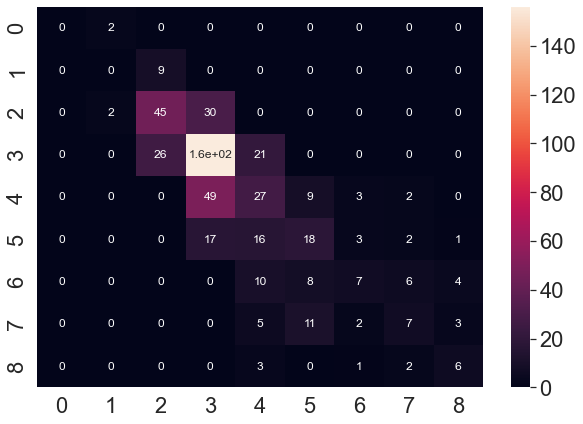

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


cm_y1 = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,7))
sn.set(font_scale=2) # for label size
sn.heatmap(cm_y1, annot=True, annot_kws={"size": 12}) # font size

plt.show()

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Dense(50, activation='relu', input_shape=(len(x_train.columns),)))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(9, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,epochs=100, batch_size=512, validation_data=(x_test, y_test))